In [71]:
!pip3 install blueqat
!pip3 install dwave-cloud-client

     |████████████████████████████████| 92kB 3.7MB/s 


In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import blueqat.wq as wq
import numpy as np
np.set_printoptions(edgeitems=70)
np.core.arrayprint._line_width = 500

import time
import PIL.Image
import IPython.display

In [30]:
a = wq.Opt()
#for sa
a.Ts  = 5    #default 5
a.R   = 0.95  #default 0.95
a.ite = 1000 #default 1000

In [69]:
U = 10 # number of units
N = 5 # number of grids

a.qubo = np.zeros((U*N,U*N), dtype=int) #creating QUBO matrix

A = [5,3,5,10,20,35,10,50,100,25]
B = [0.1,0.2,0.4,0.2,0.3,0.2,0.3,0.1,0.2,0.3]
C = [0.01,0.02,0.3,0.2,0.01,0.02,0.03,0.05,0.09,0.05]

demand = 100
Pmin = [4,5,10,6,1,25,50,3,5,20]
Pmax = [25,20,30,20,10,50,100,30,45,60]

def hi(i):
  return (Pmax[i]-Pmin[i])/N

def prod(i,k):
  return (Pmin[i]+(k)*hi(i))

# objective function
for i in range(0,U):
  for k in range(0,N):
    a.qubo[i*N+k][i*N+k] = A[i] + B[i]*prod(i,k) + C[i]*prod(i,k)**2

delta_A = 3000
delta_B = 5
additive = 0

# restriction 1
for i in range(0,U):
  for k in range(0,N):
    a.qubo[i*N+k][i*N+k] += delta_A*(1)  # 1**2
    a.qubo[i*N+k][i*N+k] += delta_A*(-2) # -2*1
    for kk in range(k+1,N):    
      a.qubo[i*N+k][i*N+kk] += delta_A*(2) # 2*1*1
  additive += delta_A*(1**2)

# restriction 2
for i in range(0,U):
  for k in range(0,N):
    a.qubo[i*N+k][i*N+k] += delta_B*(prod(i,k)**2)
    a.qubo[i*N+k][i*N+k] += delta_B*(-2*demand*prod(i,k))
    for ii in range(i,U):
      for kk in range(0,N):
        if ii == i and k > kk: continue        
        a.qubo[i*N+k][ii*N+kk] += delta_B*(2*prod(i,k)*prod(ii,kk))

additive += delta_B*(demand**2)

In [ ]:
#print(additive)
#print(a.qubo)
from matplotlib.pyplot import imshow
%matplotlib inline

#image is a numpy array
imshow(a.qubo)

In [70]:
timer = time.perf_counter()
result = a.sa(sampler="fast") #sampler="fast", shots = 100
timer = time.perf_counter() - timer 
print(f"took {timer:.3f}s\n")
format_result = np.array_split(result, U)

for i in range(0,U):
  print(format_result[i])

print("\nEnergy: " + str(a.E[-1]))
print("Energy w/ additive: " + str(a.E[-1] + additive))

took 0.068s

[1 0 0 0 0]
[0 0 0 1 0]
[0 0 1 0 0]
[0 0 0 1 0]
[0 0 0 0 1]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 1 0 0]
[0 1 0 0 0]
[0 0 0 0 0]

Energy: -57855.0
Energy w/ additive: 22145.0


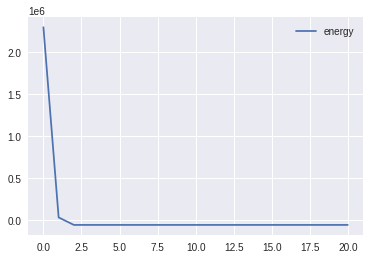

In [43]:
#print(wq.counter(result))
plt.plot(a.E, label="energy")
plt.legend()
plt.show()

In [ ]:
# D-wave
a.dwavetoken = "your token here"
a.dw()